# Models Fusion

## Set up

###  Install required packages.

In [76]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-b9oapfgd
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-b9oapfgd
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4410298df8de8ca9f13ba4ee12e6a30ec82c42d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.4 MB/s eta 0:00:00


### Unzip Data and Utils

In [2]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


In [3]:
!unzip "data.zip" -d '.'

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C05

### Import and Var

In [183]:
import warnings
warnings.filterwarnings("ignore")

In [184]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [185]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [186]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [187]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

### Split Train

In [188]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

## Individual Model

In [189]:
# for txn static, bytecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for source code
from sklearn.linear_model import LogisticRegression

# tuning
import optuna
from sklearn.metrics import f1_score

### Txn Static Feature Model

#### Base

In [190]:
df = load_feature('transaction_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

txn_X_train = df.loc[train_idx_filtered]
txn_X_test = df.loc[test_idx_filtered]
txn_y_train = y_train.loc[train_idx_filtered]
txn_y_test = y_test.loc[test_idx_filtered]

In [191]:
txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



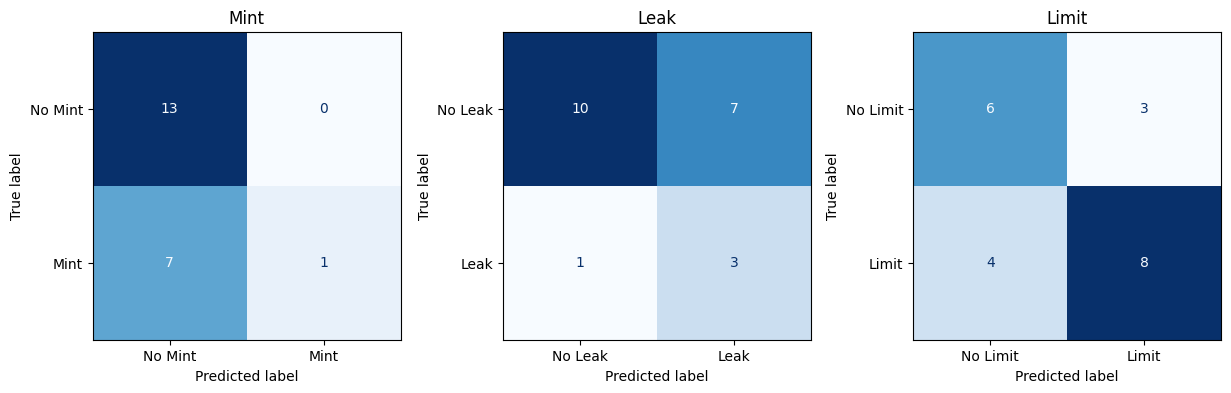

In [192]:
y_pred = txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

#### Tuning

In [193]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(txn_X_train, txn_y_train)
    y_pred = clf.predict(txn_X_test)
    return f1_score(txn_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:47:54,641] A new study created in memory with name: no-name-219442ca-5bb7-4a40-81d5-18f368541bdd
[I 2025-07-28 18:47:55,355] Trial 0 finished with value: 0.441407867494824 and parameters: {'n_estimators': 143, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 18:47:56,311] Trial 1 finished with value: 0.441407867494824 and parameters: {'n_estimators': 185, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 18:47:57,860] Trial 2 finished with value: 0.441407867494824 and parameters: {'n_estimators': 212, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 18:47:59,385] Trial 3 finished with value: 0.441407867494824 and parameters: {'n_estimators': 239, 'max_depth': 8, 'min_samples

Best Params: {'n_estimators': 143, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Score: 0.441407867494824


In [194]:
tuned_txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=143,
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.12      0.20         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.52      0.50      0.51        24
   macro avg       0.51      0.51      0.44        24
weighted avg       0.58      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



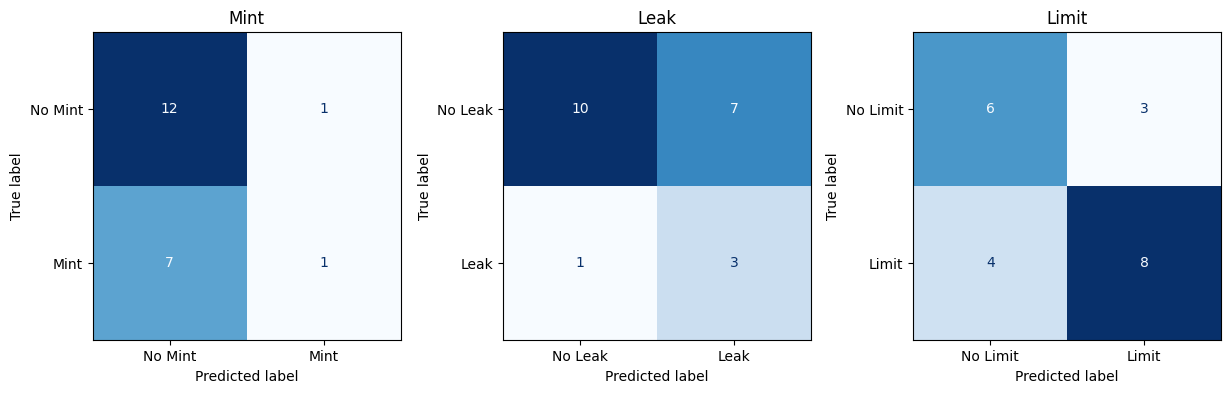

In [195]:
y_pred = tuned_txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

### Bytecode Static Feature Model

#### Base

In [196]:
df = load_feature('bytecode_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

byte_X_train = df.loc[train_idx_filtered]
byte_X_test = df.loc[test_idx_filtered]
byte_y_train = y_train.loc[train_idx_filtered]
byte_y_test = y_test.loc[test_idx_filtered]

In [197]:
byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.79      0.40      0.51        24
weighted avg       0.76      0.46      0.55        24
 samples avg       0.37      0.36      0.35        24



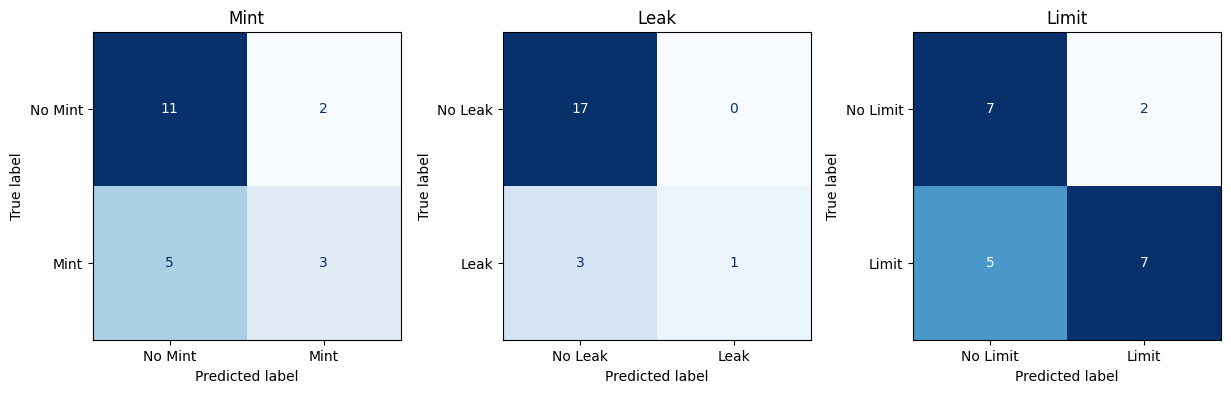

In [198]:
y_pred = byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

#### Tuning

In [200]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(byte_X_train, byte_y_train)
    y_pred = clf.predict(byte_X_test)
    return f1_score(byte_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:49:19,310] A new study created in memory with name: no-name-b1561d63-bde4-4ef7-92a2-f9c4ab7c0a14
[I 2025-07-28 18:49:20,589] Trial 0 finished with value: 0.565079365079365 and parameters: {'n_estimators': 237, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-28 18:49:21,989] Trial 1 finished with value: 0.37606837606837606 and parameters: {'n_estimators': 264, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-28 18:49:23,357] Trial 2 finished with value: 0.3428571428571428 and parameters: {'n_estimators': 280, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.565079365079365.
[I 2025-07-28 18:49:24,023] Trial 3 finished with value: 0.5760683760683761 and parameters: {'n_estimators': 120, 'max_depth': 27, 'min_

Best Params: {'n_estimators': 120, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Score: 0.5760683760683761


In [201]:
tuned_byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=27,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
                                                       n_estimators=120,
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.50      0.67         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.78      0.46      0.58        24
weighted avg       0.74      0.46      0.56        24
 samples avg       0.37      0.36      0.35        24



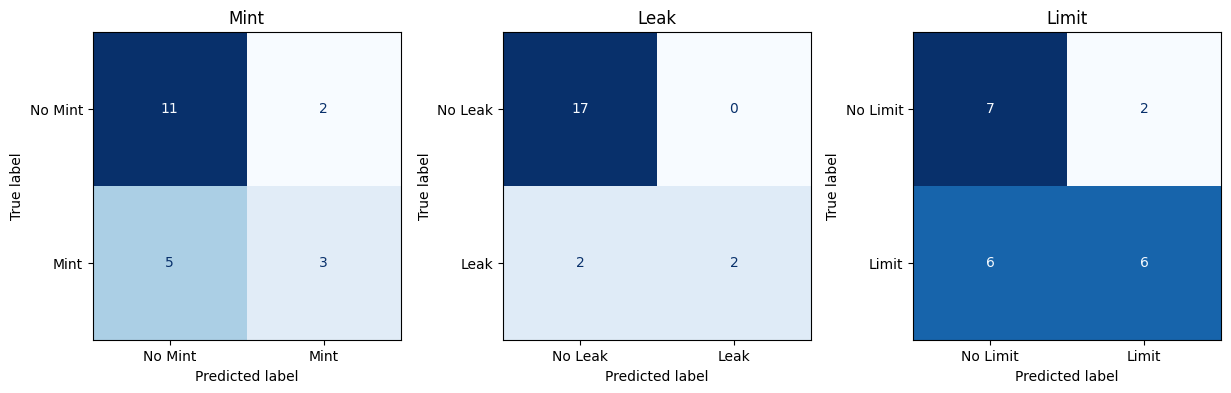

In [202]:
y_pred = tuned_byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

### Source Code Static Feature Model

#### Base

In [203]:
df = load_feature('tf_idf.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

source_X_train = df.loc[train_idx_filtered]
source_X_test = df.loc[test_idx_filtered]
source_y_train = y_train.loc[train_idx_filtered]
source_y_test = y_test.loc[test_idx_filtered]

In [204]:
source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42))
source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.86      0.63         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.62      0.59      0.60        22
   macro avg       0.75      0.55      0.55        22
weighted avg       0.72      0.59      0.59        22
 samples avg       0.50      0.43      0.44        22



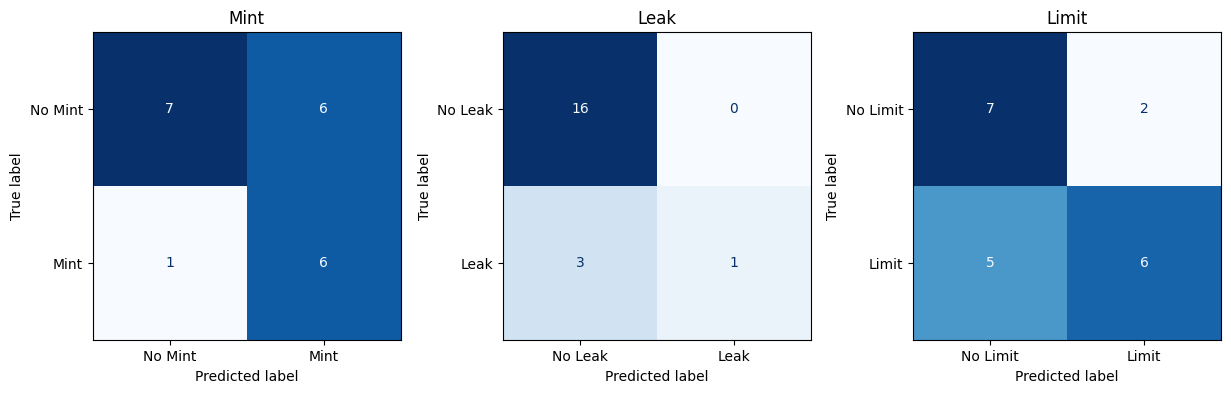

In [205]:
y_pred = source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

#### Tuning

In [206]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-3, 10, log=True),  # regularization strength
        "solver": trial.suggest_categorical(
            "solver", ["liblinear", "saga"]  # both support l1 and l2
        ),
        "max_iter": 1000
    }

    clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **params))
    clf.fit(source_X_train, source_y_train)
    y_pred = clf.predict(source_X_test)
    return f1_score(source_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:50:25,653] A new study created in memory with name: no-name-685049e1-58a0-45ee-b5bf-4c71c0267bd4
[I 2025-07-28 18:50:25,742] Trial 0 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.028620440661700074, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-07-28 18:50:28,589] Trial 1 finished with value: 0.5238095238095238 and parameters: {'penalty': 'l1', 'C': 3.255590377602483, 'solver': 'saga'}. Best is trial 1 with value: 0.5238095238095238.
[I 2025-07-28 18:50:28,685] Trial 2 finished with value: 0.1728395061728395 and parameters: {'penalty': 'l1', 'C': 0.17113214748380678, 'solver': 'saga'}. Best is trial 1 with value: 0.5238095238095238.
[I 2025-07-28 18:50:33,159] Trial 3 finished with value: 0.5238095238095238 and parameters: {'penalty': 'l1', 'C': 3.3189339551521737, 'solver': 'saga'}. Best is trial 1 with value: 0.5238095238095238.
[I 2025-07-28 18:50:33,297] Trial 4 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0

Best Params: {'penalty': 'l1', 'C': 7.430294966229116, 'solver': 'liblinear'}
Best Score: 0.6230769230769231


In [207]:
tuned_source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **study.best_params))
tuned_source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=7.430294966229116,
                                                   class_weight='balanced',
                                                   penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.83      0.71      0.77         7
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.64      0.70        11

   micro avg       0.81      0.59      0.68        22
   macro avg       0.87      0.53      0.62        22
weighted avg       0.84      0.59      0.67        22
 samples avg       0.53      0.43      0.46        22



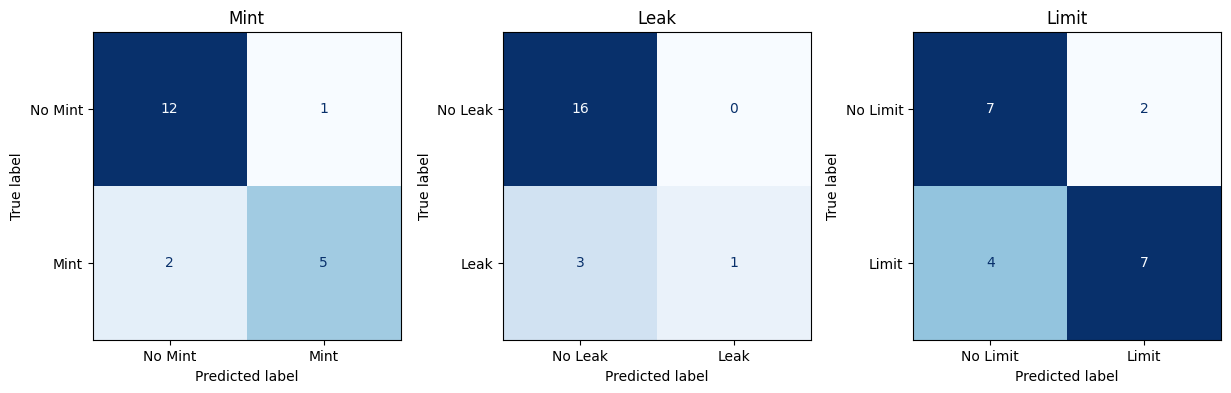

In [208]:
y_pred = tuned_source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

### Transaction Time Series

#### import lib

In [209]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

#### load data

In [210]:
seq_len = 500
feature_dim = 5

ts_X_train, ts_X_test, ts_y_train, ts_y_test  = [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("value", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0))
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        ts_X_train.append(seq)
        ts_y_train.append(y.loc[addr].tolist())
    elif addr in test_idx:
        ts_X_test.append(seq)
        ts_y_test.append(y.loc[addr].tolist())

100%|██████████| 69/69 [00:01<00:00, 38.87it/s]


In [211]:
ts_X_train = np.array(ts_X_train)
ts_X_test = np.array(ts_X_test)
ts_y_train = np.array(ts_y_train)
ts_y_test = np.array(ts_y_test)

#### tuning

In [212]:
epochs = 20

In [213]:
def build_gru_model(input_shape, units, lr, output=len(label_cols)):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        GRU(units),
        Dense(output, activation='sigmoid')  # for multilabel
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy())
    return model

In [214]:
def objective(trial):
    units = trial.suggest_int("units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=units, lr=lr)
    model.fit(ts_X_train, ts_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred = model.predict(ts_X_test)
    thresholds, _ = tune_thresholds(ts_y_test, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(ts_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:51:32,075] A new study created in memory with name: no-name-937231bd-b72f-457b-8ec7-37e6ed42d711


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Label 0: Best threshold = 0.31, Best f1 = 0.7273
Label 1: Best threshold = 0.46, Best f1 = 0.4286


[I 2025-07-28 18:52:05,687] Trial 0 finished with value: 0.6471861471861472 and parameters: {'units': 118, 'lr': 0.0034831510614320767, 'batch_size': 64}. Best is trial 0 with value: 0.6471861471861472.


Label 2: Best threshold = 0.03, Best f1 = 0.7857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Label 0: Best threshold = 0.49, Best f1 = 0.5556
Label 1: Best threshold = 0.29, Best f1 = 0.4286


[I 2025-07-28 18:52:36,892] Trial 1 finished with value: 0.5996472663139331 and parameters: {'units': 89, 'lr': 0.0006394607943097806, 'batch_size': 32}. Best is trial 0 with value: 0.6471861471861472.


Label 2: Best threshold = 0.44, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.49, Best f1 = 0.3750


[I 2025-07-28 18:52:52,944] Trial 2 finished with value: 0.5589080459770115 and parameters: {'units': 70, 'lr': 0.00023807724337744467, 'batch_size': 64}. Best is trial 0 with value: 0.6471861471861472.


Label 2: Best threshold = 0.45, Best f1 = 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.48, Best f1 = 0.4000


[I 2025-07-28 18:53:11,130] Trial 3 finished with value: 0.5596656217345872 and parameters: {'units': 85, 'lr': 0.00019769668556603024, 'batch_size': 64}. Best is trial 0 with value: 0.6471861471861472.


Label 2: Best threshold = 0.00, Best f1 = 0.7273
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Label 0: Best threshold = 0.34, Best f1 = 0.7000
Label 1: Best threshold = 0.04, Best f1 = 0.4444


[I 2025-07-28 18:53:31,110] Trial 4 finished with value: 0.6530864197530865 and parameters: {'units': 60, 'lr': 0.004346947520590834, 'batch_size': 32}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.06, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.47, Best f1 = 0.4000


[I 2025-07-28 18:53:49,083] Trial 5 finished with value: 0.5888463175819497 and parameters: {'units': 92, 'lr': 0.0002799509965206326, 'batch_size': 64}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.49, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Label 0: Best threshold = 0.22, Best f1 = 0.6667
Label 1: Best threshold = 0.11, Best f1 = 0.4000


[I 2025-07-28 18:54:18,088] Trial 6 finished with value: 0.6271604938271604 and parameters: {'units': 89, 'lr': 0.0032044257909293055, 'batch_size': 32}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.08, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.09, Best f1 = 0.4444
Label 2: Best threshold = 0.02, Best f1 = 0.7500


[I 2025-07-28 18:54:43,418] Trial 7 finished with value: 0.5820561941251596 and parameters: {'units': 100, 'lr': 0.0017176827895468423, 'batch_size': 16}. Best is trial 4 with value: 0.6530864197530865.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Label 0: Best threshold = 0.19, Best f1 = 0.5600
Label 1: Best threshold = 0.27, Best f1 = 0.4286


[I 2025-07-28 18:55:08,198] Trial 8 finished with value: 0.6011287477954145 and parameters: {'units': 104, 'lr': 0.0009682688586424924, 'batch_size': 16}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.32, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Label 0: Best threshold = 0.15, Best f1 = 0.6957
Label 1: Best threshold = 0.14, Best f1 = 0.4000


[I 2025-07-28 18:55:24,206] Trial 9 finished with value: 0.6368223295759528 and parameters: {'units': 76, 'lr': 0.005254189049660284, 'batch_size': 64}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.04, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Label 0: Best threshold = 0.21, Best f1 = 0.6957
Label 1: Best threshold = 0.09, Best f1 = 0.4444


[I 2025-07-28 18:55:41,156] Trial 10 finished with value: 0.6516371443907675 and parameters: {'units': 41, 'lr': 0.009529514213166135, 'batch_size': 32}. Best is trial 4 with value: 0.6530864197530865.


Label 2: Best threshold = 0.14, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Label 0: Best threshold = 0.10, Best f1 = 0.7273
Label 1: Best threshold = 0.41, Best f1 = 0.4286


[I 2025-07-28 18:55:57,783] Trial 11 finished with value: 0.6568863235529903 and parameters: {'units': 38, 'lr': 0.009421091522483032, 'batch_size': 32}. Best is trial 11 with value: 0.6568863235529903.


Label 2: Best threshold = 0.06, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.7273
Label 1: Best threshold = 0.37, Best f1 = 0.4286


[I 2025-07-28 18:56:15,203] Trial 12 finished with value: 0.6568863235529903 and parameters: {'units': 37, 'lr': 0.009782833122654534, 'batch_size': 32}. Best is trial 11 with value: 0.6568863235529903.


Label 2: Best threshold = 0.04, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Label 0: Best threshold = 0.11, Best f1 = 0.7273


[I 2025-07-28 18:56:32,250] Trial 13 finished with value: 0.6673326673326674 and parameters: {'units': 33, 'lr': 0.009527782266440459, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 1: Best threshold = 0.26, Best f1 = 0.4286
Label 2: Best threshold = 0.27, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Label 0: Best threshold = 0.15, Best f1 = 0.5714
Label 1: Best threshold = 0.05, Best f1 = 0.4444

[I 2025-07-28 18:56:49,654] Trial 14 finished with value: 0.6102292768959435 and parameters: {'units': 53, 'lr': 0.0017137575014018753, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.



Label 2: Best threshold = 0.33, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.7273
Label 1: Best threshold = 0.31, Best f1 = 0.4286


[I 2025-07-28 18:57:07,201] Trial 15 finished with value: 0.6673326673326674 and parameters: {'units': 34, 'lr': 0.007218307120692245, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.29, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.49, Best f1 = 0.3750


[I 2025-07-28 18:57:24,166] Trial 16 finished with value: 0.5513322884012539 and parameters: {'units': 59, 'lr': 0.00010479095641393225, 'batch_size': 16}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.00, Best f1 = 0.7273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.5714
Label 1: Best threshold = 0.17, Best f1 = 0.4286


[I 2025-07-28 18:57:40,760] Trial 17 finished with value: 0.6049382716049383 and parameters: {'units': 48, 'lr': 0.002039163284042567, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.25, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Label 0: Best threshold = 0.37, Best f1 = 0.5556
Label 1: Best threshold = 0.24, Best f1 = 0.4286


[I 2025-07-28 18:57:57,725] Trial 18 finished with value: 0.5996472663139331 and parameters: {'units': 33, 'lr': 0.006057786280274018, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.15, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.35, Best f1 = 0.4444


[I 2025-07-28 18:58:16,713] Trial 19 finished with value: 0.5987228607918264 and parameters: {'units': 67, 'lr': 0.0005191182391233849, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.48, Best f1 = 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Label 0: Best threshold = 0.20, Best f1 = 0.6154
Label 1: Best threshold = 0.16, Best f1 = 0.4286


[I 2025-07-28 18:58:33,002] Trial 20 finished with value: 0.6195902862569529 and parameters: {'units': 47, 'lr': 0.00234157452801565, 'batch_size': 16}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.23, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4444


[I 2025-07-28 18:58:50,309] Trial 21 finished with value: 0.6635327635327636 and parameters: {'units': 40, 'lr': 0.008480029450735562, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.23, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Label 0: Best threshold = 0.20, Best f1 = 0.7000
Label 1: Best threshold = 0.18, Best f1 = 0.4286


[I 2025-07-28 18:59:06,746] Trial 22 finished with value: 0.6582417582417582 and parameters: {'units': 32, 'lr': 0.006786423872157805, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 2: Best threshold = 0.32, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.7273


[I 2025-07-28 18:59:25,367] Trial 23 finished with value: 0.6621773288439955 and parameters: {'units': 45, 'lr': 0.006447383418177366, 'batch_size': 32}. Best is trial 13 with value: 0.6673326673326674.


Label 1: Best threshold = 0.10, Best f1 = 0.4444
Label 2: Best threshold = 0.13, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Label 0: Best threshold = 0.33, Best f1 = 0.7619
Label 1: Best threshold = 0.34, Best f1 = 0.4286


[I 2025-07-28 18:59:42,792] Trial 24 finished with value: 0.6684303350970017 and parameters: {'units': 55, 'lr': 0.0035162960842686245, 'batch_size': 32}. Best is trial 24 with value: 0.6684303350970017.


Label 2: Best threshold = 0.06, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Label 0: Best threshold = 0.15, Best f1 = 0.6154
Label 1: Best threshold = 0.37, Best f1 = 0.4286


[I 2025-07-28 19:00:00,534] Trial 25 finished with value: 0.6195902862569529 and parameters: {'units': 55, 'lr': 0.003289152837700496, 'batch_size': 32}. Best is trial 24 with value: 0.6684303350970017.


Label 2: Best threshold = 0.20, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Label 0: Best threshold = 0.18, Best f1 = 0.7273
Label 1: Best threshold = 0.29, Best f1 = 0.4286


[I 2025-07-28 19:00:19,849] Trial 26 finished with value: 0.6568863235529903 and parameters: {'units': 66, 'lr': 0.004574331537443494, 'batch_size': 32}. Best is trial 24 with value: 0.6684303350970017.


Label 2: Best threshold = 0.12, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Label 0: Best threshold = 0.34, Best f1 = 0.5556
Label 1: Best threshold = 0.13, Best f1 = 0.4286


[I 2025-07-28 19:00:37,988] Trial 27 finished with value: 0.5947089947089947 and parameters: {'units': 52, 'lr': 0.0011341133290470923, 'batch_size': 32}. Best is trial 24 with value: 0.6684303350970017.


Label 2: Best threshold = 0.35, Best f1 = 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.6154
Label 1: Best threshold = 0.26, Best f1 = 0.4286


[I 2025-07-28 19:00:55,609] Trial 28 finished with value: 0.6195902862569529 and parameters: {'units': 44, 'lr': 0.002609168665363691, 'batch_size': 32}. Best is trial 24 with value: 0.6684303350970017.


Label 2: Best threshold = 0.16, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.7273
Label 1: Best threshold = 0.11, Best f1 = 0.5000


[I 2025-07-28 19:01:21,695] Trial 29 finished with value: 0.6911421911421911 and parameters: {'units': 119, 'lr': 0.004167168075510282, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.17, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.7619
Label 1: Best threshold = 0.14, Best f1 = 0.4706


[I 2025-07-28 19:01:50,816] Trial 30 finished with value: 0.6824359373378982 and parameters: {'units': 126, 'lr': 0.004130876132484714, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.23, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Label 0: Best threshold = 0.30, Best f1 = 0.7273
Label 1: Best threshold = 0.10, Best f1 = 0.5000


[I 2025-07-28 19:02:17,525] Trial 31 finished with value: 0.680695847362514 and parameters: {'units': 124, 'lr': 0.0036372847950367636, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.16, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7273


[I 2025-07-28 19:02:42,340] Trial 32 finished with value: 0.6813382695735637 and parameters: {'units': 128, 'lr': 0.003914457119623877, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 1: Best threshold = 0.10, Best f1 = 0.4706
Label 2: Best threshold = 0.23, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Label 0: Best threshold = 0.22, Best f1 = 0.7619
Label 1: Best threshold = 0.10, Best f1 = 0.4444


[I 2025-07-28 19:03:10,213] Trial 33 finished with value: 0.673721340388007 and parameters: {'units': 128, 'lr': 0.004050810981759941, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.29, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Label 0: Best threshold = 0.22, Best f1 = 0.6957
Label 1: Best threshold = 0.48, Best f1 = 0.4286


[I 2025-07-28 19:03:35,596] Trial 34 finished with value: 0.6463461390997622 and parameters: {'units': 118, 'lr': 0.0011355799818937916, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.14, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Label 0: Best threshold = 0.27, Best f1 = 0.7000
Label 1: Best threshold = 0.06, Best f1 = 0.4444


[I 2025-07-28 19:04:05,355] Trial 35 finished with value: 0.6635327635327636 and parameters: {'units': 124, 'lr': 0.001435960190722281, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.09, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Label 0: Best threshold = 0.30, Best f1 = 0.7619
Label 1: Best threshold = 0.38, Best f1 = 0.4286


[I 2025-07-28 19:04:32,170] Trial 36 finished with value: 0.6788766788766788 and parameters: {'units': 112, 'lr': 0.0027273988441299086, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.16, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.25, Best f1 = 0.4286


[I 2025-07-28 19:05:01,206] Trial 37 finished with value: 0.5983701271057593 and parameters: {'units': 117, 'lr': 0.0007121866402762171, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.35, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Label 0: Best threshold = 0.25, Best f1 = 0.7273
Label 1: Best threshold = 0.09, Best f1 = 0.4706


[I 2025-07-28 19:05:27,598] Trial 38 finished with value: 0.6813382695735637 and parameters: {'units': 106, 'lr': 0.004921029247999798, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.33, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Label 0: Best threshold = 0.16, Best f1 = 0.6957
Label 1: Best threshold = 0.10, Best f1 = 0.4706


[I 2025-07-28 19:05:54,418] Trial 39 finished with value: 0.6603517413406587 and parameters: {'units': 107, 'lr': 0.004395471321873189, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.27, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Label 0: Best threshold = 0.10, Best f1 = 0.7273
Label 1: Best threshold = 0.05, Best f1 = 0.4706


[I 2025-07-28 19:06:20,303] Trial 40 finished with value: 0.6813382695735637 and parameters: {'units': 97, 'lr': 0.005382126449894981, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.13, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Label 0: Best threshold = 0.14, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4706


[I 2025-07-28 19:06:46,219] Trial 41 finished with value: 0.6722473604826545 and parameters: {'units': 97, 'lr': 0.00549354711460594, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.12, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Label 0: Best threshold = 0.07, Best f1 = 0.7273
Label 1: Best threshold = 0.05, Best f1 = 0.4706


[I 2025-07-28 19:07:10,683] Trial 42 finished with value: 0.6813382695735637 and parameters: {'units': 115, 'lr': 0.005103386931732296, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.11, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Label 0: Best threshold = 0.10, Best f1 = 0.7273
Label 1: Best threshold = 0.08, Best f1 = 0.4706


[I 2025-07-28 19:07:34,681] Trial 43 finished with value: 0.6813382695735637 and parameters: {'units': 112, 'lr': 0.0029012092256200297, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.15, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Label 0: Best threshold = 0.28, Best f1 = 0.5600
Label 1: Best threshold = 0.43, Best f1 = 0.4286


[I 2025-07-28 19:08:03,343] Trial 44 finished with value: 0.6011287477954145 and parameters: {'units': 122, 'lr': 0.0021591599052892363, 'batch_size': 64}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.32, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.7273
Label 1: Best threshold = 0.14, Best f1 = 0.4286


[I 2025-07-28 19:08:29,438] Trial 45 finished with value: 0.670995670995671 and parameters: {'units': 106, 'lr': 0.007301164400302519, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.23, Best f1 = 0.8571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Label 0: Best threshold = 0.04, Best f1 = 0.7619
Label 1: Best threshold = 0.04, Best f1 = 0.4444


[I 2025-07-28 19:08:48,796] Trial 46 finished with value: 0.6841676841676841 and parameters: {'units': 80, 'lr': 0.004129187503855513, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.09, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.6667
Label 1: Best threshold = 0.16, Best f1 = 0.4706


[I 2025-07-28 19:09:07,681] Trial 47 finished with value: 0.6611362493715435 and parameters: {'units': 77, 'lr': 0.004079225098133506, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.37, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
Label 0: Best threshold = 0.19, Best f1 = 0.6000
Label 1: Best threshold = 0.14, Best f1 = 0.4286


[I 2025-07-28 19:09:24,924] Trial 48 finished with value: 0.6047619047619047 and parameters: {'units': 83, 'lr': 0.001600342058049035, 'batch_size': 64}. Best is trial 29 with value: 0.6911421911421911.


Label 2: Best threshold = 0.28, Best f1 = 0.7857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Label 0: Best threshold = 0.48, Best f1 = 0.5556


[I 2025-07-28 19:09:53,072] Trial 49 finished with value: 0.6136528685548294 and parameters: {'units': 127, 'lr': 0.00031159993503645286, 'batch_size': 16}. Best is trial 29 with value: 0.6911421911421911.


Label 1: Best threshold = 0.22, Best f1 = 0.4706
Label 2: Best threshold = 0.49, Best f1 = 0.8148
Best Params: {'units': 119, 'lr': 0.004167168075510282, 'batch_size': 16}
Best Score: 0.6911421911421911


#### final

In [215]:
tuned_gru_model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=study.best_params['units'], lr=study.best_params['lr'])
tuned_gru_model.fit(ts_X_train, ts_y_train, epochs=epochs, batch_size=study.best_params['batch_size'], verbose=2)

Epoch 1/20
3/3 - 3s - 898ms/step - loss: 0.6870
Epoch 2/20
3/3 - 1s - 268ms/step - loss: 0.6289
Epoch 3/20
3/3 - 1s - 431ms/step - loss: 0.5589
Epoch 4/20
3/3 - 1s - 268ms/step - loss: 0.5685
Epoch 5/20
3/3 - 1s - 327ms/step - loss: 0.5405
Epoch 6/20
3/3 - 1s - 446ms/step - loss: 0.5449
Epoch 7/20
3/3 - 2s - 674ms/step - loss: 0.5328
Epoch 8/20
3/3 - 1s - 268ms/step - loss: 0.5194
Epoch 9/20
3/3 - 1s - 278ms/step - loss: 0.5068
Epoch 10/20
3/3 - 1s - 411ms/step - loss: 0.4888
Epoch 11/20
3/3 - 1s - 432ms/step - loss: 0.4772
Epoch 12/20
3/3 - 1s - 415ms/step - loss: 0.4669
Epoch 13/20
3/3 - 1s - 429ms/step - loss: 0.5230
Epoch 14/20
3/3 - 1s - 275ms/step - loss: 0.4997
Epoch 15/20
3/3 - 1s - 440ms/step - loss: 0.4947
Epoch 16/20
3/3 - 1s - 426ms/step - loss: 0.4972
Epoch 17/20
3/3 - 2s - 714ms/step - loss: 0.4924
Epoch 18/20
3/3 - 1s - 280ms/step - loss: 0.4869
Epoch 19/20
3/3 - 1s - 285ms/step - loss: 0.4790
Epoch 20/20
3/3 - 1s - 278ms/step - loss: 0.4691


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7619
Label 1: Best threshold = 0.07, Best f1 = 0.4444
Label 2: Best threshold = 0.32, Best f1 = 0.8462
              precision    recall  f1-score   support

        Mint       0.62      1.00      0.76         8
        Leak       0.29      1.00      0.44         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.56      0.96      0.71        24
   macro avg       0.56      0.97      0.68        24
weighted avg       0.65      0.96      0.75        24
 samples avg       0.46      0.64      0.51        24



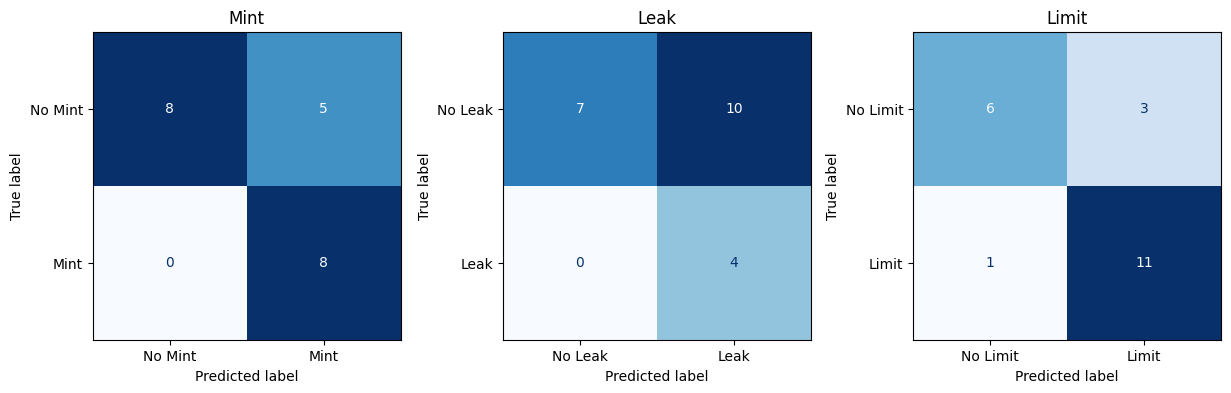

In [216]:
y_pred = tuned_gru_model.predict(ts_X_test)
thresholds, _ = tune_thresholds(ts_y_test, y_pred)

y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(ts_y_test, y_pred)

### Graph

In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

##### Load Data

In [218]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [219]:
train_dataset, test_dataset = [], []
txn_graph_y_train, txn_graph_y_test = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        txn_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        txn_graph_y_test.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [220]:
len(train_dataset), len(test_dataset)

(26, 11)

In [221]:
txn_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
txn_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [222]:
epochs = 30

In [223]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in txn_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in txn_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 19:10:20,638] A new study created in memory with name: no-name-648cda81-ea5d-41c9-af33-c065fa960365


Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:10:26,202] Trial 0 finished with value: 0.2740740740740741 and parameters: {'hidden_dim': 63, 'lr': 0.00016099411275507676, 'dropout': 0.4492585004764072}. Best is trial 0 with value: 0.2740740740740741.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 19:10:32,876] Trial 1 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 116, 'lr': 3.0763188844610426e-06, 'dropout': 0.5018137898613501}. Best is trial 0 with value: 0.2740740740740741.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:10:41,148] Trial 2 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 134, 'lr': 9.044577691979074e-06, 'dropout': 0.05863523120816261}. Best is trial 0 with value: 0.2740740740740741.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:10:55,727] Trial 3 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 234, 'lr': 1.703077349184158e-05, 'dropout': 0.4605485037049857}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 19:11:04,029] Trial 4 finished with value: 0.2074074074074074 and parameters: {'hidden_dim': 160, 'lr': 9.317774304876499e-06, 'dropout': 0.15288059021806585}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:11:19,185] Trial 5 finished with value: 0.0 and parameters: {'hidden_dim': 227, 'lr': 0.0051128665888721, 'dropout': 0.1248731074760686}. Best is trial 3 with value: 0.3333333333333333.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:11:25,056] Trial 6 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 100, 'lr': 0.0007905027481247074, 'dropout': 0.48289968240244846}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:11:31,686] Trial 7 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 109, 'lr': 3.266185145334943e-05, 'dropout': 0.12740615997968466}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:11:35,518] Trial 8 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 66, 'lr': 0.008928888034530777, 'dropout': 0.4352141570467243}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:11:44,041] Trial 9 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 113, 'lr': 0.0023959446526624134, 'dropout': 0.29459068967384455}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:12:06,821] Trial 10 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 249, 'lr': 0.0001482970241818798, 'dropout': 0.7591589105448695}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:12:25,103] Trial 11 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 192, 'lr': 0.0007308337644840594, 'dropout': 0.6078651853013906}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:12:45,883] Trial 12 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 177, 'lr': 0.0005958777823966448, 'dropout': 0.2998398806146694}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:12:57,669] Trial 13 finished with value: 0.3246753246753247 and parameters: {'hidden_dim': 195, 'lr': 3.9114171869874064e-05, 'dropout': 0.2737360847172038}. Best is trial 3 with value: 0.3333333333333333.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:13:17,290] Trial 14 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 192, 'lr': 1.2054541283329701e-06, 'dropout': 0.30321731989204914}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:13:36,790] Trial 15 finished with value: 0.0 and parameters: {'hidden_dim': 228, 'lr': 0.0004199189984686853, 'dropout': 0.5678672362859833}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:13:45,770] Trial 16 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 162, 'lr': 4.369732178418832e-05, 'dropout': 0.6982530282138273}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:14:01,517] Trial 17 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 250, 'lr': 9.892945552250831e-06, 'dropout': 0.362484752975805}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:14:20,295] Trial 18 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 222, 'lr': 0.0020628525938665514, 'dropout': 0.21377059556995495}. Best is trial 3 with value: 0.3333333333333333.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 19:14:23,801] Trial 19 finished with value: 0.35555555555555557 and parameters: {'hidden_dim': 37, 'lr': 0.0002770073826241419, 'dropout': 0.38245643595563306}. Best is trial 19 with value: 0.35555555555555557.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:14:26,805] Trial 20 finished with value: 0.25555555555555554 and parameters: {'hidden_dim': 42, 'lr': 7.896728689827181e-05, 'dropout': 0.5936710588897621}. Best is trial 19 with value: 0.35555555555555557.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:14:41,461] Trial 21 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 178, 'lr': 0.00033630091153098187, 'dropout': 0.3617439714521908}. Best is trial 19 with value: 0.35555555555555557.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:14:48,105] Trial 22 finished with value: 0.0 and parameters: {'hidden_dim': 84, 'lr': 0.001368003290890803, 'dropout': 0.38663872360163243}. Best is trial 19 with value: 0.35555555555555557.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:00,498] Trial 23 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 135, 'lr': 0.0002815944324066577, 'dropout': 0.22950131236849866}. Best is trial 19 with value: 0.35555555555555557.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:13,001] Trial 24 finished with value: 0.0 and parameters: {'hidden_dim': 213, 'lr': 1.8722099051902586e-05, 'dropout': 0.5037640216135572}. Best is trial 19 with value: 0.35555555555555557.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:20,753] Trial 25 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 154, 'lr': 8.470661848614958e-05, 'dropout': 0.3356572501200109}. Best is trial 25 with value: 0.3703703703703704.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:24,424] Trial 26 finished with value: 0.15079365079365079 and parameters: {'hidden_dim': 42, 'lr': 8.575050876118518e-05, 'dropout': 0.5478755230422454}. Best is trial 25 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:15:33,036] Trial 27 finished with value: 0.4305555555555555 and parameters: {'hidden_dim': 154, 'lr': 4.3206005608604255e-06, 'dropout': 0.6656372224057798}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:40,985] Trial 28 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 152, 'lr': 1.091019858059714e-06, 'dropout': 0.748361652963807}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:49,818] Trial 29 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 130, 'lr': 3.2600420375481587e-06, 'dropout': 0.6688565601670856}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:55,292] Trial 30 finished with value: 0.0 and parameters: {'hidden_dim': 84, 'lr': 0.00017622344260655954, 'dropout': 0.42956383932950115}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:15:59,318] Trial 31 finished with value: 0.2740740740740741 and parameters: {'hidden_dim': 61, 'lr': 1.9712978218749683e-05, 'dropout': 0.6675987108923878}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:16:21,914] Trial 32 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 169, 'lr': 5.895088412862631e-06, 'dropout': 0.3608042463171476}. Best is trial 27 with value: 0.4305555555555555.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:16:30,156] Trial 33 finished with value: 0.46388888888888885 and parameters: {'hidden_dim': 149, 'lr': 2.4128398260184868e-06, 'dropout': 0.5003693902144208}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.2500


[I 2025-07-28 19:16:36,798] Trial 34 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 140, 'lr': 2.8820301335298175e-06, 'dropout': 0.5398845882587546}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:16:43,399] Trial 35 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 122, 'lr': 2.0468544654992456e-06, 'dropout': 0.5028922394916893}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:16:50,754] Trial 36 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 147, 'lr': 5.618747398741355e-06, 'dropout': 0.7924838254771172}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:16:58,544] Trial 37 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 154, 'lr': 1.6240578474987048e-06, 'dropout': 0.4116366948855289}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:17:05,669] Trial 38 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 127, 'lr': 5.159708194445873e-06, 'dropout': 0.05448753016267577}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:10,547] Trial 39 finished with value: 0.4083333333333334 and parameters: {'hidden_dim': 97, 'lr': 1.0933268470937618e-05, 'dropout': 0.6324442212586462}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:15,460] Trial 40 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 98, 'lr': 1.0121098479344327e-05, 'dropout': 0.6210654697210474}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:20,077] Trial 41 finished with value: 0.29523809523809524 and parameters: {'hidden_dim': 67, 'lr': 3.5192921416420536e-06, 'dropout': 0.46023795877212154}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:23,457] Trial 42 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 34, 'lr': 1.4218129154187459e-05, 'dropout': 0.6397895170758131}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:29,631] Trial 43 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 102, 'lr': 5.145417916077988e-05, 'dropout': 0.6901716441048268}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:42,456] Trial 44 finished with value: 0.0 and parameters: {'hidden_dim': 172, 'lr': 0.00015839639435411736, 'dropout': 0.3266374602412433}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:17:50,000] Trial 45 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 144, 'lr': 2.5914860259284655e-05, 'dropout': 0.7286290844094231}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:11,519] Trial 46 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 117, 'lr': 1.9551700937644466e-06, 'dropout': 0.48227210295641465}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:21,502] Trial 47 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 183, 'lr': 6.432533646652877e-06, 'dropout': 0.24319610385977633}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:29,525] Trial 48 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 162, 'lr': 5.7706391764977595e-05, 'dropout': 0.0019233691747455595}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:33,613] Trial 49 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 53, 'lr': 0.00020822133244500368, 'dropout': 0.5685360295920486}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:39,984] Trial 50 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 81, 'lr': 0.0010163758682209553, 'dropout': 0.15541954990389686}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:45,631] Trial 51 finished with value: 0.0 and parameters: {'hidden_dim': 103, 'lr': 5.24334813859506e-05, 'dropout': 0.689371657577404}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:51,097] Trial 52 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 92, 'lr': 0.00011221559703633702, 'dropout': 0.6530018226511359}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:18:56,722] Trial 53 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 112, 'lr': 3.0627854106255885e-05, 'dropout': 0.7111384389027119}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:19:04,192] Trial 54 finished with value: 0.0 and parameters: {'hidden_dim': 138, 'lr': 1.3058484313234183e-05, 'dropout': 0.5951571978763202}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:19:12,738] Trial 55 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 160, 'lr': 0.00011579747993969836, 'dropout': 0.7975328609550011}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:19:33,402] Trial 56 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 207, 'lr': 0.0005267391032142161, 'dropout': 0.7525229824397355}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:19:45,155] Trial 57 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 156, 'lr': 0.00011351856619129471, 'dropout': 0.7784804476327558}. Best is trial 33 with value: 0.46388888888888885.


Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:19:55,666] Trial 58 finished with value: 0.0 and parameters: {'hidden_dim': 159, 'lr': 9.076647888455207e-05, 'dropout': 0.7388283288357662}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:20:05,905] Trial 59 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 186, 'lr': 4.176160781233752e-06, 'dropout': 0.7860042472417512}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:20:21,102] Trial 60 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 169, 'lr': 0.00011751161949850713, 'dropout': 0.7683971476644621}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:20:30,794] Trial 61 finished with value: 0.0 and parameters: {'hidden_dim': 148, 'lr': 0.00025833745830639504, 'dropout': 0.37613447504650876}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:20:40,931] Trial 62 finished with value: 0.0 and parameters: {'hidden_dim': 156, 'lr': 0.0003719116383687927, 'dropout': 0.3281609842432018}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:20:50,122] Trial 63 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 163, 'lr': 2.5964497366223166e-06, 'dropout': 0.41047368840858084}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:20:57,641] Trial 64 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 125, 'lr': 6.994656638663847e-05, 'dropout': 0.718871045094418}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 19:21:05,027] Trial 65 finished with value: 0.0 and parameters: {'hidden_dim': 138, 'lr': 7.519281673443908e-06, 'dropout': 0.5289713386867665}. Best is trial 33 with value: 0.46388888888888885.


Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:21:23,091] Trial 66 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 174, 'lr': 0.00023480233025512467, 'dropout': 0.7840056237829046}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:21:30,617] Trial 67 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 132, 'lr': 0.00013684558327882408, 'dropout': 0.7999381383667303}. Best is trial 33 with value: 0.46388888888888885.


Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:21:41,870] Trial 68 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 199, 'lr': 1.577772464785357e-06, 'dropout': 0.43901765081082167}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:21:51,634] Trial 69 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 148, 'lr': 0.004577622417545479, 'dropout': 0.623908371699788}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:22:07,820] Trial 70 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 183, 'lr': 0.0005282676282805683, 'dropout': 0.338499841264568}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:22:20,433] Trial 71 finished with value: 0.38181818181818183 and parameters: {'hidden_dim': 166, 'lr': 6.37078245131745e-05, 'dropout': 0.660961462192522}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:22:28,816] Trial 72 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 152, 'lr': 6.849353193205934e-05, 'dropout': 0.2775098312840495}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:22:38,478] Trial 73 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 167, 'lr': 4.093998096872106e-05, 'dropout': 0.5654710839587358}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:22:48,372] Trial 74 finished with value: 0.0 and parameters: {'hidden_dim': 142, 'lr': 0.00019683253829760503, 'dropout': 0.6874234105694704}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000


[I 2025-07-28 19:22:56,684] Trial 75 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 156, 'lr': 2.36515473977785e-05, 'dropout': 0.7663604726069648}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.5000


[I 2025-07-28 19:23:07,568] Trial 76 finished with value: 0.38888888888888884 and parameters: {'hidden_dim': 179, 'lr': 2.9086865557067977e-05, 'dropout': 0.6653819909289458}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:23:17,695] Trial 77 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 191, 'lr': 3.229113705648087e-05, 'dropout': 0.6588182298122848}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:23:28,966] Trial 78 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 200, 'lr': 7.935330741005307e-06, 'dropout': 0.6297679149143658}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:23:39,390] Trial 79 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 178, 'lr': 2.354375663395649e-05, 'dropout': 0.5968657339395831}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:23:47,535] Trial 80 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 153, 'lr': 1.1143132335768178e-05, 'dropout': 0.7104431189894501}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:24:03,412] Trial 81 finished with value: 0.0 and parameters: {'hidden_dim': 165, 'lr': 1.919388083439171e-05, 'dropout': 0.741740844665252}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:24:12,058] Trial 82 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 157, 'lr': 1.4825201166915167e-05, 'dropout': 0.7785629870342197}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:24:24,273] Trial 83 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 176, 'lr': 3.999131554033598e-05, 'dropout': 0.7619124503483161}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:24:31,768] Trial 84 finished with value: 0.0 and parameters: {'hidden_dim': 146, 'lr': 2.5558504529850937e-05, 'dropout': 0.6740415050379668}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:24:41,805] Trial 85 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 162, 'lr': 9.571496570633615e-05, 'dropout': 0.706122963206009}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:24:53,362] Trial 86 finished with value: 0.2740740740740741 and parameters: {'hidden_dim': 171, 'lr': 5.7183687357477676e-05, 'dropout': 0.6447490204322937}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 19:25:07,234] Trial 87 finished with value: 0.0 and parameters: {'hidden_dim': 183, 'lr': 0.0001399535880932374, 'dropout': 0.7275297652198269}. Best is trial 33 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:14,803] Trial 88 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 135, 'lr': 4.099677206770447e-06, 'dropout': 0.682431617124162}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:22,046] Trial 89 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 152, 'lr': 7.162536957947208e-05, 'dropout': 0.7638353692363011}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:28,668] Trial 90 finished with value: 0.0 and parameters: {'hidden_dim': 121, 'lr': 3.049751836911361e-05, 'dropout': 0.6085534749754423}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:38,534] Trial 91 finished with value: 0.0 and parameters: {'hidden_dim': 160, 'lr': 0.00011288813846752119, 'dropout': 0.486553130125855}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:47,861] Trial 92 finished with value: 0.0 and parameters: {'hidden_dim': 142, 'lr': 0.0002937017732463009, 'dropout': 0.5177698642492361}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:25:58,766] Trial 93 finished with value: 0.0 and parameters: {'hidden_dim': 166, 'lr': 0.00016500424165884336, 'dropout': 0.39068203428602843}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:26:02,469] Trial 94 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 62, 'lr': 2.485833255754817e-06, 'dropout': 0.5778046368708277}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:26:11,584] Trial 95 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 129, 'lr': 8.59823588321534e-05, 'dropout': 0.30395026280574533}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:26:15,771] Trial 96 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 70, 'lr': 4.6336234660465306e-05, 'dropout': 0.7413869441249483}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 19:26:26,200] Trial 97 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 189, 'lr': 1.478673303376111e-06, 'dropout': 0.3449561861651681}. Best is trial 33 with value: 0.46388888888888885.


Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:26:30,224] Trial 98 finished with value: 0.46388888888888885 and parameters: {'hidden_dim': 51, 'lr': 1.700806000472173e-05, 'dropout': 0.6633431759259001}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 19:26:33,440] Trial 99 finished with value: 0.2341269841269841 and parameters: {'hidden_dim': 43, 'lr': 1.1735323166203039e-05, 'dropout': 0.6645217310837735}. Best is trial 33 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Best Params: {'hidden_dim': 149, 'lr': 2.4128398260184868e-06, 'dropout': 0.5003693902144208}
Best Score: 0.46388888888888885


##### Final

Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
              precision    recall  f1-score   support

        Mint       0.27      1.00      0.43         3
        Leak       0.09      1.00      0.17         1
       Limit       0.00      0.00      0.00         5

   micro avg       0.18      0.44      0.26         9
   macro avg       0.12      0.67      0.20         9
weighted avg       0.10      0.44      0.16         9
 samples avg       0.18      0.18      0.18         9



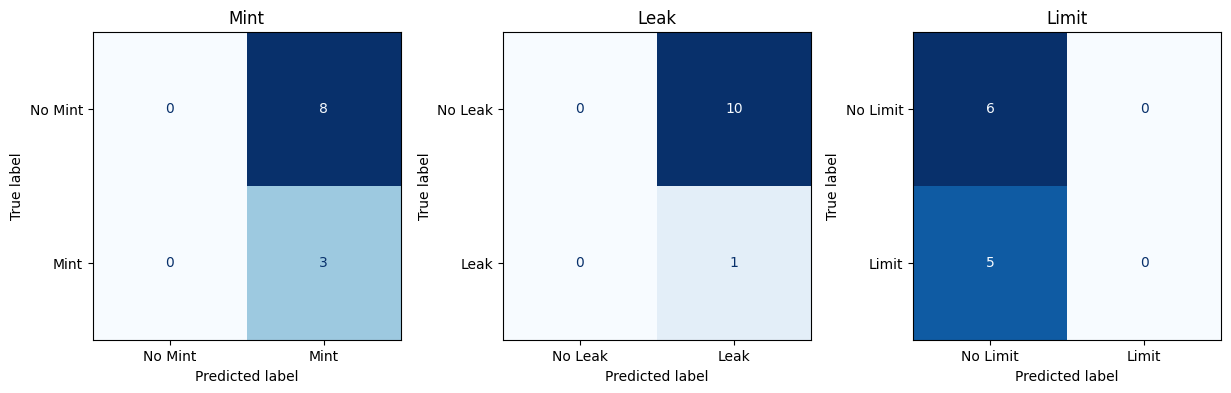

In [224]:
# Model setup
tuned_txn_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_txn_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_txn_gcn_model.train()
for epoch in range(epochs):
    for batch in txn_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_txn_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_txn_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in txn_graph_test_loader:
        out = tuned_txn_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### Control Flow

##### Load Data

In [225]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [226]:
train_dataset, test_dataset = [], []
cfg_graph_y_train, cfg_graph_y_test = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        cfg_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        cfg_graph_y_test.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [227]:
len(train_dataset), len(test_dataset)

(47, 20)

In [228]:
cfg_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
cfg_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [229]:
epochs = 30

In [230]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in cfg_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in cfg_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 19:26:41,556] A new study created in memory with name: no-name-bb5fa803-feef-46b5-9207-1b51ffac4857


Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:26:48,891] Trial 0 finished with value: 0.3206349206349206 and parameters: {'hidden_dim': 188, 'lr': 0.004373430178637385, 'dropout': 0.48859293012987415}. Best is trial 0 with value: 0.3206349206349206.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:26:53,140] Trial 1 finished with value: 0.041666666666666664 and parameters: {'hidden_dim': 105, 'lr': 2.6929258932292907e-05, 'dropout': 0.6279768898422101}. Best is trial 0 with value: 0.3206349206349206.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:26:56,668] Trial 2 finished with value: 0.4157509157509158 and parameters: {'hidden_dim': 41, 'lr': 1.3048966083570654e-05, 'dropout': 0.6201422349944232}. Best is trial 2 with value: 0.4157509157509158.


Label 2: Best threshold = 0.01, Best f1 = 0.7857
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:27:00,387] Trial 3 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 88, 'lr': 0.0001082656800204834, 'dropout': 0.653241990409557}. Best is trial 2 with value: 0.4157509157509158.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:06,490] Trial 4 finished with value: 0.19259259259259257 and parameters: {'hidden_dim': 165, 'lr': 2.3120949922397617e-05, 'dropout': 0.3621263176758562}. Best is trial 2 with value: 0.4157509157509158.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:11,305] Trial 5 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 104, 'lr': 6.34936778820348e-06, 'dropout': 0.17847353426597926}. Best is trial 2 with value: 0.4157509157509158.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478


[I 2025-07-28 19:27:17,540] Trial 6 finished with value: 0.44618894256575414 and parameters: {'hidden_dim': 176, 'lr': 1.9210884089158912e-06, 'dropout': 0.48679689335666326}. Best is trial 6 with value: 0.44618894256575414.


Label 2: Best threshold = 0.01, Best f1 = 0.7407
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:20,834] Trial 7 finished with value: 0.34767025089605735 and parameters: {'hidden_dim': 44, 'lr': 2.2427450682030488e-06, 'dropout': 0.24982264860926753}. Best is trial 6 with value: 0.44618894256575414.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333


[I 2025-07-28 19:27:29,017] Trial 8 finished with value: 0.33464052287581697 and parameters: {'hidden_dim': 193, 'lr': 0.0037557051558654766, 'dropout': 0.21632090188923636}. Best is trial 6 with value: 0.44618894256575414.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:38,021] Trial 9 finished with value: 0.33283950617283947 and parameters: {'hidden_dim': 219, 'lr': 1.8551221995566232e-06, 'dropout': 0.3638073043499199}. Best is trial 6 with value: 0.44618894256575414.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:47,057] Trial 10 finished with value: 0.30952380952380953 and parameters: {'hidden_dim': 240, 'lr': 0.00043152444390204443, 'dropout': 0.03652083909983117}. Best is trial 6 with value: 0.44618894256575414.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:50,109] Trial 11 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 33, 'lr': 1.131688055738172e-06, 'dropout': 0.7766806051225764}. Best is trial 6 with value: 0.44618894256575414.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:27:55,531] Trial 12 finished with value: 0.5003077368668767 and parameters: {'hidden_dim': 145, 'lr': 9.186084666980852e-06, 'dropout': 0.5628712771484093}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 19:28:01,615] Trial 13 finished with value: 0.42571306939123027 and parameters: {'hidden_dim': 139, 'lr': 5.772830125999561e-06, 'dropout': 0.4899308571441075}. Best is trial 12 with value: 0.5003077368668767.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.01, Best f1 = 0.7586
Label 0: Best threshold = 0.01, Best f1 = 0.5600
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:06,788] Trial 14 finished with value: 0.3136507936507937 and parameters: {'hidden_dim': 140, 'lr': 9.133415245597283e-05, 'dropout': 0.5092474667499461}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:13,823] Trial 15 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 167, 'lr': 5.011869508569293e-06, 'dropout': 0.779617810357049}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:21,134] Trial 16 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 208, 'lr': 8.835326567881834e-05, 'dropout': 0.5584211859071487}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:26,091] Trial 17 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 120, 'lr': 0.0011231517098848804, 'dropout': 0.4339573842162876}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4615


[I 2025-07-28 19:28:31,998] Trial 18 finished with value: 0.39819004524886886 and parameters: {'hidden_dim': 160, 'lr': 3.099182692072352e-05, 'dropout': 0.3226418537378023}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:41,775] Trial 19 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 248, 'lr': 3.44277332079457e-06, 'dropout': 0.6986452701415167}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:45,265] Trial 20 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 69, 'lr': 1.0623118702594448e-06, 'dropout': 0.4357252107018162}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5217
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:28:50,467] Trial 21 finished with value: 0.49265602888791293 and parameters: {'hidden_dim': 129, 'lr': 9.648781052166267e-06, 'dropout': 0.5322073991243372}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5600
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:28:55,827] Trial 22 finished with value: 0.29777777777777775 and parameters: {'hidden_dim': 119, 'lr': 1.1348243481546167e-05, 'dropout': 0.5673400669122068}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5263


[I 2025-07-28 19:29:02,448] Trial 23 finished with value: 0.39766081871345027 and parameters: {'hidden_dim': 181, 'lr': 1.2758249420860607e-05, 'dropout': 0.550713788815048}. Best is trial 12 with value: 0.5003077368668767.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:09,059] Trial 24 finished with value: 0.0 and parameters: {'hidden_dim': 151, 'lr': 5.431876913729292e-05, 'dropout': 0.6861556564271472}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:29:13,967] Trial 25 finished with value: 0.29022988505747127 and parameters: {'hidden_dim': 130, 'lr': 0.00021933773913260953, 'dropout': 0.43758044181728095}. Best is trial 12 with value: 0.5003077368668767.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:18,613] Trial 26 finished with value: 0.3106332138590203 and parameters: {'hidden_dim': 85, 'lr': 2.760242708470237e-06, 'dropout': 0.5840445945674608}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:25,211] Trial 27 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 177, 'lr': 7.5280463283453846e-06, 'dropout': 0.3216325919402925}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:34,185] Trial 28 finished with value: 0.3861728395061728 and parameters: {'hidden_dim': 219, 'lr': 1.6744420686079245e-05, 'dropout': 0.518894192317009}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:41,418] Trial 29 finished with value: 0.3055555555555555 and parameters: {'hidden_dim': 197, 'lr': 3.637476354268748e-06, 'dropout': 0.717327302403406}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:29:48,007] Trial 30 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 151, 'lr': 4.9445999625173705e-05, 'dropout': 0.47573796403157353}. Best is trial 12 with value: 0.5003077368668767.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.01, Best f1 = 0.8148


[I 2025-07-28 19:29:53,357] Trial 31 finished with value: 0.4382716049382716 and parameters: {'hidden_dim': 135, 'lr': 8.357253000494798e-06, 'dropout': 0.48000106745322263}. Best is trial 12 with value: 0.5003077368668767.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:29:59,175] Trial 32 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 126, 'lr': 1.66021345663129e-06, 'dropout': 0.6130217198899014}. Best is trial 32 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:03,637] Trial 33 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 109, 'lr': 1.6665431188852904e-06, 'dropout': 0.6142924818479407}. Best is trial 32 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4615


[I 2025-07-28 19:30:08,722] Trial 34 finished with value: 0.5632447998039396 and parameters: {'hidden_dim': 122, 'lr': 1.047117269748845e-06, 'dropout': 0.6223553535506319}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 19:30:13,034] Trial 35 finished with value: 0.3395061728395062 and parameters: {'hidden_dim': 86, 'lr': 3.837982719095994e-06, 'dropout': 0.6632299587828892}. Best is trial 34 with value: 0.5632447998039396.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:17,378] Trial 36 finished with value: 0.2333333333333333 and parameters: {'hidden_dim': 106, 'lr': 1.0602060457792384e-06, 'dropout': 0.6348233851378136}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:22,996] Trial 37 finished with value: 0.3833658219623131 and parameters: {'hidden_dim': 123, 'lr': 2.0136291410750997e-05, 'dropout': 0.7447135689429154}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:26,394] Trial 38 finished with value: 0.0 and parameters: {'hidden_dim': 68, 'lr': 2.9252978830846397e-05, 'dropout': 0.6113363284561832}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 19:30:30,459] Trial 39 finished with value: 0.0 and parameters: {'hidden_dim': 94, 'lr': 2.322721051223422e-06, 'dropout': 0.5408556225706074}. Best is trial 34 with value: 0.5632447998039396.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:37,158] Trial 40 finished with value: 0.15151515151515152 and parameters: {'hidden_dim': 153, 'lr': 8.656673135495159e-06, 'dropout': 0.589991169680712}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:44,515] Trial 41 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 174, 'lr': 1.7774489338808224e-06, 'dropout': 0.6384987181393198}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:50,227] Trial 42 finished with value: 0.39040529363110005 and parameters: {'hidden_dim': 128, 'lr': 1.5020007514330668e-06, 'dropout': 0.38230883439989943}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:30:54,855] Trial 43 finished with value: 0.4172839506172839 and parameters: {'hidden_dim': 111, 'lr': 4.578658819245524e-06, 'dropout': 0.6695609519715015}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.01, Best f1 = 0.7333
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:00,476] Trial 44 finished with value: 0.31 and parameters: {'hidden_dim': 144, 'lr': 2.3634899068847343e-06, 'dropout': 0.5243411532913937}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:05,029] Trial 45 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 98, 'lr': 1.570803158052722e-06, 'dropout': 0.46292877566814883}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:09,156] Trial 46 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 97, 'lr': 1.0407049000310474e-06, 'dropout': 0.40707515582488196}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:31:12,486] Trial 47 finished with value: 0.12121212121212122 and parameters: {'hidden_dim': 64, 'lr': 5.7085580167876085e-06, 'dropout': 0.04487090291869594}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:17,855] Trial 48 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 115, 'lr': 3.217708767555658e-06, 'dropout': 0.736966178167578}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:21,379] Trial 49 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 80, 'lr': 2.9454999100682707e-06, 'dropout': 0.749566786057552}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 19:31:26,450] Trial 50 finished with value: 0.2888888888888889 and parameters: {'hidden_dim': 117, 'lr': 0.008203987991311714, 'dropout': 0.7489321570905324}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3750


[I 2025-07-28 19:31:31,110] Trial 51 finished with value: 0.47561728395061725 and parameters: {'hidden_dim': 99, 'lr': 1.4640594706380287e-06, 'dropout': 0.5971167628579969}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:31:36,481] Trial 52 finished with value: 0.0 and parameters: {'hidden_dim': 134, 'lr': 4.775985518216447e-06, 'dropout': 0.4656785046523883}. Best is trial 34 with value: 0.5632447998039396.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:42,515] Trial 53 finished with value: 0.0 and parameters: {'hidden_dim': 113, 'lr': 2.2462812655289286e-06, 'dropout': 0.7004269965679165}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:31:47,552] Trial 54 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 126, 'lr': 1.0634035072270819e-05, 'dropout': 0.6502508759777695}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:31:54,371] Trial 55 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 161, 'lr': 1.4483271015288538e-06, 'dropout': 0.7931461709125759}. Best is trial 34 with value: 0.5632447998039396.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3529


[I 2025-07-28 19:32:00,284] Trial 56 finished with value: 0.2904865649963689 and parameters: {'hidden_dim': 162, 'lr': 1.564190441672056e-06, 'dropout': 0.7303489975626578}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3810


[I 2025-07-28 19:32:06,317] Trial 57 finished with value: 0.3635432667690732 and parameters: {'hidden_dim': 140, 'lr': 1.3732876759493985e-06, 'dropout': 0.6844978223660855}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:12,352] Trial 58 finished with value: 0.37222222222222223 and parameters: {'hidden_dim': 158, 'lr': 0.001105559760677832, 'dropout': 0.7964950888730092}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:32:15,342] Trial 59 finished with value: 0.0 and parameters: {'hidden_dim': 50, 'lr': 3.5144833869899368e-06, 'dropout': 0.7713496890225242}. Best is trial 34 with value: 0.5632447998039396.


Label 0: Best threshold = 0.01, Best f1 = 0.5556
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:21,682] Trial 60 finished with value: 0.48677248677248675 and parameters: {'hidden_dim': 146, 'lr': 2.1812642404610625e-06, 'dropout': 0.5693249897939434}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:28,154] Trial 61 finished with value: 0.43101810917902866 and parameters: {'hidden_dim': 167, 'lr': 6.772330782319644e-06, 'dropout': 0.5352237357593755}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:33,483] Trial 62 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 120, 'lr': 3.01765616989573e-06, 'dropout': 0.7112877192850451}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:32:37,760] Trial 63 finished with value: 0.3577712609970674 and parameters: {'hidden_dim': 102, 'lr': 1.0300785354627657e-06, 'dropout': 0.4540564764284054}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:42,742] Trial 64 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 128, 'lr': 4.476628069906748e-06, 'dropout': 0.5012302168051068}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:48,628] Trial 65 finished with value: 0.2735632183908046 and parameters: {'hidden_dim': 137, 'lr': 1.6262118716493183e-05, 'dropout': 0.5778448539463673}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:54,236] Trial 66 finished with value: 0.20317460317460315 and parameters: {'hidden_dim': 145, 'lr': 0.0001738212199398624, 'dropout': 0.6226866218748097}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:32:59,531] Trial 67 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 114, 'lr': 1.950764224743911e-06, 'dropout': 0.4079246061953021}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:33:06,380] Trial 68 finished with value: 0.35232668566001896 and parameters: {'hidden_dim': 186, 'lr': 4.3773596149159154e-05, 'dropout': 0.3265455231497206}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:33:12,194] Trial 69 finished with value: 0.22839506172839505 and parameters: {'hidden_dim': 132, 'lr': 1.3255730457802673e-06, 'dropout': 0.5016608840971934}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:33:16,101] Trial 70 finished with value: 0.4202898550724637 and parameters: {'hidden_dim': 92, 'lr': 6.637391559697973e-06, 'dropout': 0.5536790799774044}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478


[I 2025-07-28 19:33:21,574] Trial 71 finished with value: 0.3525011687704535 and parameters: {'hidden_dim': 146, 'lr': 2.468918455163223e-06, 'dropout': 0.5789398022487654}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:33:28,586] Trial 72 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 171, 'lr': 1.9644458825914916e-06, 'dropout': 0.7971728896839018}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:33:34,740] Trial 73 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 157, 'lr': 2.8452824910129272e-06, 'dropout': 0.5538084976083504}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:33:38,918] Trial 74 finished with value: 0.28417818740399386 and parameters: {'hidden_dim': 78, 'lr': 1.3088383899793381e-06, 'dropout': 0.6013478035324857}. Best is trial 34 with value: 0.5632447998039396.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:33:43,295] Trial 75 finished with value: 0.34767025089605735 and parameters: {'hidden_dim': 107, 'lr': 3.7541691240917555e-06, 'dropout': 0.5237268213607748}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478


[I 2025-07-28 19:33:48,527] Trial 76 finished with value: 0.28878153515834676 and parameters: {'hidden_dim': 123, 'lr': 9.853549105450461e-06, 'dropout': 0.6743803783176912}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:33:54,518] Trial 77 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 150, 'lr': 2.052466064565059e-06, 'dropout': 0.6505684856104538}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3636


[I 2025-07-28 19:34:00,761] Trial 78 finished with value: 0.12121212121212122 and parameters: {'hidden_dim': 138, 'lr': 1.557587117556377e-05, 'dropout': 0.44479963414816803}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:07,062] Trial 79 finished with value: 0.37237076648841355 and parameters: {'hidden_dim': 153, 'lr': 5.755174886901347e-06, 'dropout': 0.771178846836963}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:11,184] Trial 80 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 104, 'lr': 1.679642248796285e-06, 'dropout': 0.623355761556154}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:16,557] Trial 81 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 115, 'lr': 1.328963287208323e-06, 'dropout': 0.5993808696123798}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:20,765] Trial 82 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 101, 'lr': 1.2104312786471015e-06, 'dropout': 0.5618548627013562}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:24,733] Trial 83 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 97, 'lr': 2.8900265320508037e-06, 'dropout': 0.49091688630374103}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:30,319] Trial 84 finished with value: 0.31989247311827956 and parameters: {'hidden_dim': 123, 'lr': 1.698502233600897e-06, 'dropout': 0.7284315490605877}. Best is trial 34 with value: 0.5632447998039396.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.7692
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.01, Best f1 = 0.7586


[I 2025-07-28 19:34:34,026] Trial 85 finished with value: 0.6045219148667424 and parameters: {'hidden_dim': 88, 'lr': 4.260657852248196e-06, 'dropout': 0.575280001641238}. Best is trial 85 with value: 0.6045219148667424.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:37,782] Trial 86 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 79, 'lr': 3.9918498673875915e-06, 'dropout': 0.5313118132722191}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:43,986] Trial 87 finished with value: 0.36891793754538854 and parameters: {'hidden_dim': 142, 'lr': 4.88036880091383e-06, 'dropout': 0.5718006996511751}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:48,997] Trial 88 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 130, 'lr': 8.166510459391337e-06, 'dropout': 0.13090623715381006}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:34:54,136] Trial 89 finished with value: 0.37573805689747725 and parameters: {'hidden_dim': 110, 'lr': 2.5197528049823824e-06, 'dropout': 0.6388088819443298}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.01, Best f1 = 0.7692


[I 2025-07-28 19:34:57,438] Trial 90 finished with value: 0.4013377926421405 and parameters: {'hidden_dim': 72, 'lr': 2.3711226184374633e-05, 'dropout': 0.5084695622784536}. Best is trial 85 with value: 0.6045219148667424.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:35:01,297] Trial 91 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 92, 'lr': 1.5075642581387418e-06, 'dropout': 0.6072162350300602}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:35:05,841] Trial 92 finished with value: 0.4365591397849462 and parameters: {'hidden_dim': 99, 'lr': 1.0111348834776636e-06, 'dropout': 0.5878391209757425}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:35:10,063] Trial 93 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 85, 'lr': 3.1846694728105724e-06, 'dropout': 0.5411065120708175}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 19:35:13,854] Trial 94 finished with value: 0.2998236331569665 and parameters: {'hidden_dim': 89, 'lr': 2.2331571374892233e-06, 'dropout': 0.4249244272306911}. Best is trial 85 with value: 0.6045219148667424.


Label 1: Best threshold = 0.01, Best f1 = 0.3810
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4286


[I 2025-07-28 19:35:18,901] Trial 95 finished with value: 0.3794162826420891 and parameters: {'hidden_dim': 118, 'lr': 1.9227060019742576e-06, 'dropout': 0.6889862129452496}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:35:24,439] Trial 96 finished with value: 0.30617283950617286 and parameters: {'hidden_dim': 133, 'lr': 1.3407615902183604e-05, 'dropout': 0.47966185696194374}. Best is trial 85 with value: 0.6045219148667424.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:35:30,044] Trial 97 finished with value: 0.25641025641025644 and parameters: {'hidden_dim': 149, 'lr': 1.1839352724229668e-06, 'dropout': 0.6368872343569104}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.01, Best f1 = 0.7692
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 19:35:35,264] Trial 98 finished with value: 0.3009259259259259 and parameters: {'hidden_dim': 107, 'lr': 1.6211377670743258e-06, 'dropout': 0.7592690824957108}. Best is trial 85 with value: 0.6045219148667424.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5714
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 19:35:41,469] Trial 99 finished with value: 0.2793650793650793 and parameters: {'hidden_dim': 165, 'lr': 0.0005237472916149268, 'dropout': 0.6641339382467613}. Best is trial 85 with value: 0.6045219148667424.


Best Params: {'hidden_dim': 88, 'lr': 4.260657852248196e-06, 'dropout': 0.575280001641238}
Best Score: 0.6045219148667424


##### Final

Label 0: Best threshold = 0.01, Best f1 = 0.8333
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
              precision    recall  f1-score   support

        Mint       1.00      0.71      0.83         7
        Leak       0.20      1.00      0.33         4
       Limit       0.55      1.00      0.71        11

   micro avg       0.44      0.91      0.60        22
   macro avg       0.58      0.90      0.63        22
weighted avg       0.63      0.91      0.68        22
 samples avg       0.42      0.57      0.47        22



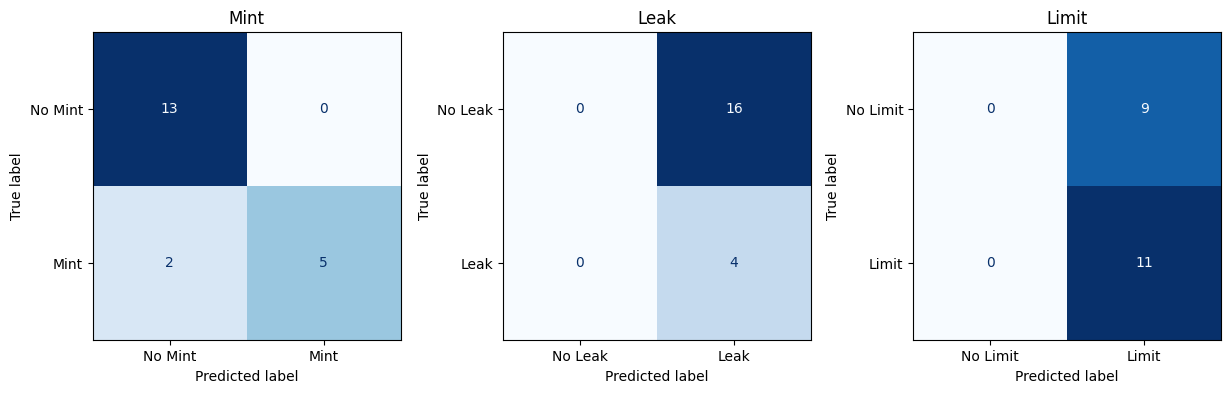

In [231]:
# Model setup
tuned_cfg_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_cfg_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_cfg_gcn_model.train()
for epoch in range(epochs):
    for batch in cfg_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_cfg_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_cfg_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in cfg_graph_test_loader:
        out = tuned_cfg_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

## Fusion

### Track Which Model Can Predict Which Address

In [232]:
# For each model, create a dict of predictions and a set of supported addresses
available_preds = {}
available_y_true = {}

for model_name, model_obj, X_test, y_test in [
    ("txn", tuned_txn_model, txn_X_test, txn_y_test),
    ("byte", tuned_byte_model, byte_X_test, byte_y_test),
    ("source", tuned_source_model, source_X_test, source_y_test),
    ("timeseries", tuned_gru_model, ts_X_test, ts_y_test),
    ("txn_gcn", tuned_txn_gcn_model, txn_graph_test_loader, txn_graph_y_test),
    ("cfg_gcn", tuned_cfg_gcn_model, cfg_graph_test_loader, cfg_graph_y_test)
]:
    # Store predictions and ground truths
    preds = model_obj.predict(X_test) if not "gcn" in model_name and model_name != "timeseries" else ...
    available_preds[model_name] = dict(zip(X_test.index, preds))
    available_y_true[model_name] = dict(zip(X_test.index, y_test))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

### Option A: Majority Voting

In [ ]:
from collections import defaultdict, Counter

A_final_preds = {}
for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    label_votes = []
    for model_name, preds in available_preds.items():
        if addr in preds:
            label_votes.append(preds[addr])

    # Majority vote across models
    if label_votes:
        # Convert to array and round mean for voting
        fused = np.round(np.mean(label_votes, axis=0)).astype(int)
        A_final_preds[addr] = fused


In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(A_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([A_final_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)

### Option B: Weighted Averaging

In [ ]:
weights = {
    "txn": 0.15,
    "byte": 0.2,
    "source": 0.2,
    "timeseries": 0.15,
    "txn_gcn": 0.15,
    "cfg_gcn": 0.15
}

B_final_preds = {}
for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = 0

    for model_name, preds in available_preds.items():
        if addr in preds:
            weighted_sum += weights[model_name] * preds[addr]
            total_weight += weights[model_name]

    fused = (weighted_sum / total_weight > 0.5).astype(int)
    B_final_preds[addr] = fused


In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(B_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([B_final_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)
